In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-reviews/Reviews.csv


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Data Ingestion and Preprocessing:

In [4]:
df=pd.read_csv("/kaggle/input/amazon-product-reviews/Reviews.csv")

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [8]:
df.shape

(568454, 10)

#### Removing unneccessary Columns

In [9]:
df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1,inplace=True)

In [10]:
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [14]:
## Checking Missing Values
df.isna().sum()

Score    0
Text     0
dtype: int64

In [19]:

print('Number of Duplicate in the dataset:',df.duplicated().sum())

Number of Duplicate in the dataset: 174779


#### Here no **missing** values but  have **duplicate** values, need to be removed

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.duplicated().sum()

0

In [24]:
df.shape

(393675, 2)

### EDA ( Exploratery Data Analysis)

In [28]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

<Axes: xlabel='Score', ylabel='count'>

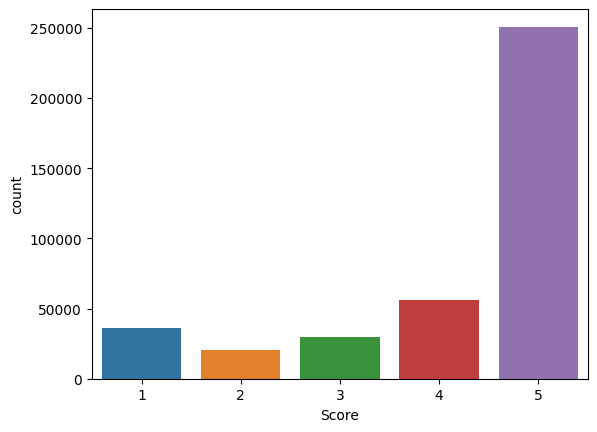

In [32]:
sns.countplot(x=df['Score'])

#### Here We can Majority class is 5 , imbalanced classes in the dataset

In [37]:
df['Score'].value_counts()

Score
5    250745
4     56074
1     36280
3     29772
2     20804
Name: count, dtype: int64

In [39]:
df['Score'].value_counts()/len(df)*100

Score
5    63.693402
4    14.243729
1     9.215724
3     7.562583
2     5.284562
Name: count, dtype: float64

### observation 
#### 63% value scores are 5 in the dataset, so high volume of product reviews are positve

### Taking Samples from each scores 

In [47]:
df1=df.groupby('Score').apply(lambda x: x.sample(20800)).reset_index(drop=True)

<ipython-input-47-0faaced037b7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1=df.groupby('Score').apply(lambda x: x.sample(20800)).reset_index(drop=True)


#### By taking **20800** samples from each **score** , the data become balanced and we have 104000 raw data

In [49]:
df1.shape

(104000, 2)

In [50]:
df1['Score'].value_counts()

Score
1    20800
2    20800
3    20800
4    20800
5    20800
Name: count, dtype: int64

<Axes: xlabel='Score', ylabel='count'>

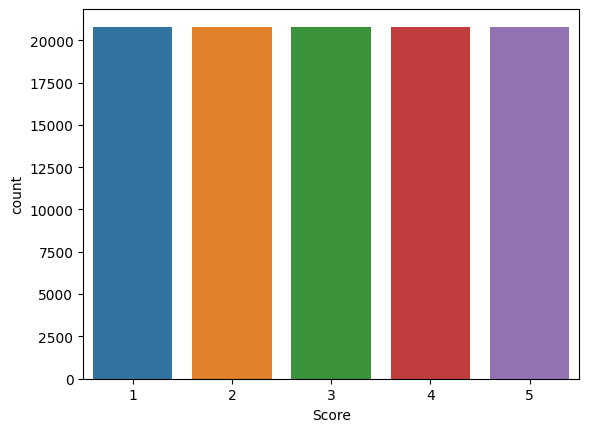

In [52]:
sns.countplot(x=df1['Score'])

##### As shown,```Score``` Column is balanced and each value have the same distribution so the model won't be biased to specific value.

### Text Preprocessing

In [56]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer,PorterStemmer


In [59]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [60]:
stop_words=set(stopwords.words('english'))

In [67]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [69]:
stemming=PorterStemmer()